# Retrieving light curve information for an ANTARES Watched Object

In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from astropy import stats

from antares_client.search import search
from dl import queryClient as qc

watched_object_id = 3717 # get this from the URL of the watched object
response = requests.get(f'https://antares.noao.edu/api/alerts/?watched_object_id={watched_object_id}')
data = json.loads(response.content)
print(f"Got {data['count']} Alerts")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [122]:
def get_locus_id_by_alert_id(alert_id):
    query = {
        "query": {
            "match": {
                "alert_id": alert_id
            }
        }
    }
    alerts = search(query)
    if not alerts:
        return None
    return alerts[0].get("locus_id")


def get_alerts_by_locus_id(locus_id):
    query = {
        "query": {
            "match": {
                "locus_id": locus_id
            }
        }
    }
    return search(query)


def get_time_series_by_alert_id(alert_id, *names, **kw):
    """See docs for `get_time_series_by_locus_id`"""
    locus_id = get_locus_id_by_alert_id(alert_id)
    return get_time_series_by_locus_id(locus_id, *names, **kw)
 

def get_time_series_by_locus_id(locus_id, *names, **kw):
    """
    Get a numpy array of alert properties.

    Output is a ``numpy.array`` with multiple rows:

    ====  ======================================================
    Row   Content
    ====  ======================================================
    1     alert IDs
    2     alert timestamps (in MJD such as ``58270.1676619998``)
    3..N  one row per property in ``names``
    ====  ======================================================

    :param names: Property names to fetch
    :type names: list of str
    :param filters: (Optional keyword argument) A dict of property names and
        values. If given, the output array will only include alerts which
        match the filters.
    :type filters: dict
    :param require: (Optional keyword argument) Property names to require in
        output. Alerts are skipped if they have no value for any of the
        listed properties.
    :type require: list of str
    :param require_all: (Optional keyword argument) If True, an alert is
        skipped if it has no value for any of the requested ``*names``.
    :type require_all: bool

    :return: numpy.array
    """
    filters = kw.get('filters', {})
    names = ('alert_id', 'mjd') + names  # Include the two header rows
    values = [[] for _ in names]

    require = kw.get('require', [])
    require_all = kw.get('require_all', False)

    for alert in get_alerts_by_locus_id(locus_id):
        # Skip alerts which fail the filters in `filters`
        skip = False
        for name, value in filters.items():
            test_value = alert.get(name) or alert["properties"].get(name)
            if test_value:
                try:
                    if type(value)(test_value) != value:
                        skip = True
                        break
                except TypeError:
                    skip = True
                    break
            else:
                skip = True
                break
        if skip:
            continue

        # Skip alerts if missing any values from `require`
        if require:
            skip = False
            for name in require:
                if alert.get(name) is None and alert["properties"].get(name) is None:
                    skip = True
                    break
            if skip:
                continue

        # Skip alerts which are missing any values, if `require_all` is True
        if require_all:
            skip = False
            for name in names:
                if alert.get(name) is None and alert["properties"].get(name) is None:
                    skip = True
                    break
            if skip:
                continue

        # Collect property values
        for i, name in enumerate(names):
            value = alert.get(name) or alert["properties"].get(name)
            if value is None:
                value = np.NaN
            values[i].append(value)

    return np.array(values, dtype=object)




In [123]:
locus_ids = [alert['locus_id'] for alert in data['result']]
print(locus_ids)

[47512, 13461, 5993816, 48101, 5720467, 13461, 13461, 2688779, 13460, 47530, 47530, 13461, 13461, 2994091, 2770575, 47530, 13461, 13461, 2688779, 13461, 47530, 13461, 47530, 47530, 13461, 47530, 47512, 13461, 47530, 13461, 2688779, 13461, 47530, 47530, 13461, 47530, 13461, 13461, 47530, 13461, 1136571, 13461, 47530, 47512, 47530, 47530, 483425, 13461, 13461, 47512, 13461, 4498295, 4699151, 4500845, 3905042, 4498607, 3909928, 2197499, 3911017, 2197501, 4498078, 4498456, 3904768, 3909974, 3904732, 3905022, 4500896, 2197440, 2197476, 2197497, 3910464, 4498593, 4498374, 13461, 13461, 13461, 47512, 13461, 483427, 483427, 3046847, 13461, 13461, 13461, 4498295, 3904768, 2197501, 4498607, 4501128, 4500884, 2197440, 4498374, 4501103, 3904732, 3904660, 3905022, 3904688, 4500896, 4500845, 4498456, 3905042, 4500883, 2197476, 4498078, 4500911, 2197497, 4498593, 3910464, 3909974, 3911017, 13460, 2688779, 13461, 47512, 483427, 3898613, 48101, 13461, 48101, 483427, 13460, 13461, 48101, 13461, 13461, 1

In [124]:
uq_locus_id = np.unique(np.array(locus_ids)).tolist()

In [125]:
print(len(uq_locus_id))

59


In [126]:
locus_id = uq_locus_id[0]
alert_id, mjd, passband, mag, magerr, zeropoint, ra, dec = get_time_series_by_locus_id(
    locus_id,
    'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf', 'ztf_magzpsci', 'ra', 'dec',
    require=['ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf'],
)
# BUG: Make sure you typecast to the dtypes you expect
alert_id = alert_id.astype(int)
passband = passband.astype(int)
mjd = mjd.astype(float)
mag = mag.astype(float)
magerr = magerr.astype(float)
zeropoint = zeropoint.astype(float)
ra = ra.astype(float)
dec = dec.astype(float)

tmplist = list(zip(np.full_like(alert_id,locus_id), alert_id, mjd, passband, mag, magerr, ra, dec))



In [127]:
dftmp = pd.DataFrame(tmplist,columns=['locus_id','alert_id', 'mjd', 'passband', 'mag', 'magerr', 'ra', 'dec'])

In [128]:
dftmp

,locus_id,alert_id,mjd,passband,mag,magerr,ra,dec
0,13460,86687,58278.221343,1,20.233688,0.162320,227.105771,67.158145
1,13460,2129608,58363.180764,1,19.682585,0.142297,227.106041,67.158218
2,13460,90098778,58668.197755,1,20.340500,0.215667,227.105882,67.158224
3,13460,90099224,58680.196632,1,19.784901,0.271126,227.105732,67.158072
4,13460,24025319,58633.321308,2,20.323799,0.260816,227.105708,67.158215
5,13460,24025321,58636.330775,2,20.542000,0.228797,227.105792,67.158246
6,13460,16279,58272.266806,1,20.414412,0.189146,227.105664,67.158205
7,13460,5273736,58377.197743,1,19.723354,0.155472,227.105872,67.158209
8,13460,90098657,58665.264526,2,20.367399,0.183248,227.105611,67.158216
9,13460,90099343,58682.203275,1,20.016001,0.259305,227.105844,67.158231


In [129]:
fgrp = dftmp.groupby(['passband'])

In [130]:
fgrp.get_group(1)

,locus_id,alert_id,mjd,passband,mag,magerr,ra,dec
0,13460,86687,58278.221343,1,20.233688,0.162320,227.105771,67.158145
1,13460,2129608,58363.180764,1,19.682585,0.142297,227.106041,67.158218
2,13460,90098778,58668.197755,1,20.340500,0.215667,227.105882,67.158224
3,13460,90099224,58680.196632,1,19.784901,0.271126,227.105732,67.158072
6,13460,16279,58272.266806,1,20.414412,0.189146,227.105664,67.158205
7,13460,5273736,58377.197743,1,19.723354,0.155472,227.105872,67.158209
9,13460,90099343,58682.203275,1,20.016001,0.259305,227.105844,67.158231
10,13460,90098533,58694.306956,1,19.666576,0.148859,227.105926,67.158244
11,13460,24025315,58639.268530,1,19.629255,0.157886,227.105850,67.158186
12,13460,17390931,58616.286655,1,19.739710,0.162846,227.105928,67.158256


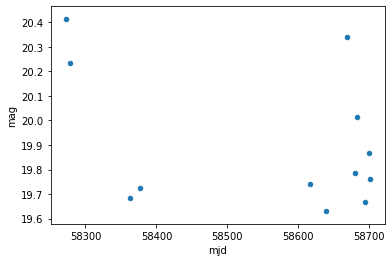

In [131]:
fgrp.get_group(1).plot(kind='scatter',x='mjd',y='mag',)

In [ ]:
def main():
    # Get lightcurve for each locus
    for locus_id in uq_locus_id:
        alert_id, mjd, passband, mag, magerr, zeropoint = get_time_series_by_locus_id(
            locus_id,
            'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf', 'ztf_magzpsci',
            require=['ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf'],
        )
        # BUG: Make sure you typecast to the dtypes you expect
        alert_id = alert_id.astype(int)
        passband = passband.astype(int)
        mjd = mjd.astype(float)
        mag = mag.astype(float)
        magerr = magerr.astype(float)
        zeropoint = zeropoint.astype(float)
        print(list(zip(alert_id, passband, mag, magerr)))

main()

In [132]:
query = {
  "query": {
    "terms": {
      "locus_id": uq_locus_id
    }
  }
}

In [133]:
result_set = search(query)
for a in result_set:
    a.update(a.pop('properties'))

In [134]:
df = pd.DataFrame(result_set)

In [135]:
print(df.columns.values)

['alert_id' 'survey' 'original_id' 'ra' 'dec' 'htm20' 'mjd' 'locus_id'
 'ingest_time' 'ztf_fid' 'ztf_pid' 'ztf_programid' 'ztf_candid'
 'ztf_tblid' 'ztf_nid' 'ztf_rcid' 'ztf_field' 'ztf_nneg' 'ztf_nbad'
 'ztf_ndethist' 'ztf_ncovhist' 'ztf_tooflag' 'ztf_objectidps1'
 'ztf_objectidps2' 'ztf_objectidps3' 'ztf_nmtchps' 'ztf_rfid'
 'ztf_nframesref' 'ztf_nmatches' 'provenance_id' 'ztf_jd' 'ztf_diffmaglim'
 'ztf_xpos' 'ztf_ypos' 'ztf_ra' 'ztf_dec' 'ztf_magpsf' 'ztf_sigmapsf'
 'ztf_chipsf' 'ztf_magap' 'ztf_sigmagap' 'ztf_distnr' 'ztf_magnr'
 'ztf_sigmagnr' 'ztf_chinr' 'ztf_sharpnr' 'ztf_sky' 'ztf_magdiff'
 'ztf_fwhm' 'ztf_classtar' 'ztf_mindtoedge' 'ztf_magfromlim'
 'ztf_seeratio' 'ztf_aimage' 'ztf_bimage' 'ztf_aimagerat' 'ztf_bimagerat'
 'ztf_elong' 'ztf_rb' 'ztf_ssdistnr' 'ztf_ssmagnr' 'ztf_sumrat'
 'ztf_magapbig' 'ztf_sigmagapbig' 'ztf_ranr' 'ztf_decnr' 'ztf_sgmag1'
 'ztf_srmag1' 'ztf_simag1' 'ztf_szmag1' 'ztf_sgscore1' 'ztf_distpsnr1'
 'ztf_jdstarthist' 'ztf_jdendhist' 'ztf_scorr' 'ztf_sgm

In [136]:
plt.scatter(dfm['ra'],dfm['dec'])

NameError: name 'dfm' is not defined

In [137]:
ra0 = 227.285
dec0 = 67.222
radius = 0.5
columns = 'ra,dec,g_r,mag_r'

sql = '''
    SELECT {0} FROM ls_dr8.tractor_n
    WHERE Q3C_RADIAL_QUERY(ra,dec,{1},{2},{3})
    AND mag_r != 'nan' AND mag_r != 'Infinity'
'''.format(columns,ra0,dec0,radius)


In [138]:
print(sql)


    SELECT ra,dec,g_r,mag_r FROM ls_dr8.tractor_n
    WHERE Q3C_RADIAL_QUERY(ra,dec,227.285,67.222,0.5)
    AND mag_r != 'nan' AND mag_r != 'Infinity'



In [139]:
%%time
df0 = qc.query(sql=sql,fmt='pandas')

CPU times: user 106 ms, sys: 19 ms, total: 125 ms
Wall time: 757 ms


In [140]:
len(df0)

76211

In [141]:
dff = df[df['mag'].notna()]

In [142]:
dff

,alert_id,survey,original_id,ra,dec,htm20,mjd,locus_id,ingest_time,ztf_fid,...,ztf_drb,ztf_drbversion,streams,anomaly_dmdt_score,gw_last_proc_status,astrorapid_error_log_id,astrorapid_error,astrorapid_skipped,astrorapid_success,rapid_class_probability_AGN
0,16712789,1,854349860915015013,227.584417,66.996991,14843126133318,58608.349861,47530,1557045146,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26712399,1,879321300915010000,226.960818,67.157555,14842970412993,58633.321308,483425,1559975137,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,66843476,1,924275280915015002,227.307197,67.259313,14842997365742,58678.275289,13461,1563086739,1,...,0.9990155696868896,d6_m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,68629333,1,927205860915015002,227.465112,67.231887,14843001889874,58681.205868,483427,1563339930,1,...,0.9999957084655762,d6_m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,59753438,1,917198550915015001,227.584360,66.997004,14843126133318,58671.198553,47530,1562475385,2,...,1,d6_m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,78861145,1,934330990915015003,227.403346,67.025023,14843080747239,58688.330995,47567,1563986958,1,...,0.9999989867210388,d6_m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,71025588,1,929244880915015000,227.307304,67.259229,14842997365609,58683.244884,13461,1563517956,2,...,0.9997733235359192,d6_m7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,69166176,1,911264520915015007,227.584420,66.997008,14843126133318,58665.264526,47530,1563426128,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,69166211,1,920197430915015007,227.584321,66.996986,14843126133318,58674.197431,47530,1563426128,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,68629350,1,897283530915015000,227.465169,67.231792,14843001890727,58651.283530,483427,1563339930,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
dff['mag'] = dff['mag'].apply(pd.to_numeric)

/data0/sw/antares-kernel/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
loc_grp = dff.groupby(['locus_id','ztf_fid'])

In [145]:
loc_grp.count().columns.values

array(['alert_id', 'survey', 'original_id', 'ra', 'dec', 'htm20', 'mjd',
       'ingest_time', 'ztf_pid', 'ztf_programid', 'ztf_candid',
       'ztf_tblid', 'ztf_nid', 'ztf_rcid', 'ztf_field', 'ztf_nneg',
       'ztf_nbad', 'ztf_ndethist', 'ztf_ncovhist', 'ztf_tooflag',
       'ztf_objectidps1', 'ztf_objectidps2', 'ztf_objectidps3',
       'ztf_nmtchps', 'ztf_rfid', 'ztf_nframesref', 'ztf_nmatches',
       'provenance_id', 'ztf_jd', 'ztf_diffmaglim', 'ztf_xpos',
       'ztf_ypos', 'ztf_ra', 'ztf_dec', 'ztf_magpsf', 'ztf_sigmapsf',
       'ztf_chipsf', 'ztf_magap', 'ztf_sigmagap', 'ztf_distnr',
       'ztf_magnr', 'ztf_sigmagnr', 'ztf_chinr', 'ztf_sharpnr', 'ztf_sky',
       'ztf_magdiff', 'ztf_fwhm', 'ztf_classtar', 'ztf_mindtoedge',
       'ztf_magfromlim', 'ztf_seeratio', 'ztf_aimage', 'ztf_bimage',
       'ztf_aimagerat', 'ztf_bimagerat', 'ztf_elong', 'ztf_rb',
       'ztf_ssdistnr', 'ztf_ssmagnr', 'ztf_sumrat', 'ztf_magapbig',
       'ztf_sigmagapbig', 'ztf_ranr', 'ztf_decnr', 'ztf

In [146]:
dfmean = loc_grp.mean()

In [147]:
dfmean

alert_id  survey          original_id          ra  \
locus_id ztf_fid                                                          
13460    1        7.793592e+07     1.0   918634342165014912  227.105905   
         2        8.668953e+07     1.0   917016790915010048  227.105721   
13461    1        9.936840e+07     1.0   917369238020278400  227.307248   
         2        1.035264e+08     1.0   928027930915015168  227.307331   
47512    1        1.066090e+08     1.0   923332955460465920  227.350153   
...                        ...     ...                  ...         ...   
4501103  1        1.163069e+08     1.0   948306730915015040  227.580161   
4501128  1        1.163136e+08     1.0   948306730915015040  227.511503   
4699151  1        1.366759e+08     1.0   959221130915015040  227.252541   
5720467  1        2.154032e+08     1.0   997178360915015040  227.582679   
5993816  2        2.669333e+08     1.0  1019138660915010048  226.860416   

                        dec         htm20           mjd   ingest_time  \
locus_id ztf_fid                                                        
13460    1        67.158218  1.484297e+13  58672.634346  1.563166e+09   
         2        67.158235  1.484297e+13  58671.016797  1.563279e+09   
13461    1        67.259263  1.484300e+13  58671.369242  1.562512e+09   
         2        67.259247  1.484300e+13  58682.027935  1.563417e+09   
47512    1        67.101003  1.484296e+13  58677.332960  1.564100e+09   
...                     ...           ...           ...           ...   
4501103  1        67.082400  1.484299e+13  58702.306736  1.565169e+09   
4501128  1        67.065150  1.484299e+13  58702.306736  1.565169e+09   
4699151  1        67.213301  1.484300e+13  58713.221134  1.566111e+09   
5720467  1        67.087237  1.484299e+13  58751.178368  1.569451e+09   
5993816  2        67.168434  1.484297e+13  58773.138669  1.571307e+09   

                        mag  
locus_id ztf_fid             
13460    1        19.850500  
         2        20.353507  
13461    1        18.395682  
         2        17.494330  
47512    1        20.360727  
...                     ...  
4501103  1        17.471655  
4501128  1        18.732655  
4699151  1        16.871090  
5720467  1        19.869434  
5993816  2        18.258886  

[71 rows x 9 columns]

In [148]:
dfmean_g = dfmean.xs('1', level = 'ztf_fid')
dfmean_r = dfmean.xs('2', level = 'ztf_fid')
dfmean_g.columns = dfmean_g.columns + '_g'
dfmean_r.columns = dfmean_r.columns + '_r'

In [149]:
dfmean_gr = pd.concat([dfmean_g, dfmean_r], axis=1, join='inner')

In [150]:
dfmean_gr

,alert_id_g,survey_g,original_id_g,ra_g,dec_g,htm20_g,mjd_g,ingest_time_g,mag_g,alert_id_r,survey_r,original_id_r,ra_r,dec_r,htm20_r,mjd_r,ingest_time_r,mag_r
locus_id,,,,,,,,,,,,,,,,,,
13460,7.793592e+07,1.0,918634342165014912,227.105905,67.158218,1.484297e+13,58672.634346,1.563166e+09,19.850500,8.668953e+07,1.0,917016790915010048,227.105721,67.158235,1.484297e+13,58671.016797,1.563279e+09,20.353507
13461,9.936840e+07,1.0,917369238020278400,227.307248,67.259263,1.484300e+13,58671.369242,1.562512e+09,18.395682,1.035264e+08,1.0,928027930915015168,227.307331,67.259247,1.484300e+13,58682.027935,1.563417e+09,17.494330
47512,1.066090e+08,1.0,923332955460465920,227.350153,67.101003,1.484296e+13,58677.332960,1.564100e+09,20.360727,1.115255e+08,1.0,927861068607322752,227.350233,67.100982,1.484296e+13,58681.861074,1.563984e+09,19.962459
47530,1.078731e+08,1.0,925814097757119360,227.584432,66.996995,1.484313e+13,58679.814101,1.563544e+09,19.595371,1.000247e+08,1.0,912553445315015040,227.584381,66.996999,1.484313e+13,58666.553449,1.562200e+09,19.172043
48101,1.251242e+08,1.0,946402477581681664,227.356932,67.203756,1.484300e+13,58700.402483,1.565142e+09,19.747447,1.036141e+08,1.0,936912418415014912,227.356901,67.203755,1.484300e+13,58690.912422,1.564265e+09,20.052359
483425,8.075936e+07,1.0,936203530915015040,226.960598,67.157563,1.484297e+13,58690.203530,1.564117e+09,19.941895,9.283956e+07,1.0,923796660915012608,226.960717,67.157534,1.484297e+13,58677.796667,1.563438e+09,20.484787
483427,8.785215e+07,1.0,904954995915015040,227.465074,67.231856,1.484300e+13,58658.955000,1.561695e+09,19.622234,9.575847e+07,1.0,924238255915015040,227.465160,67.231812,1.484300e+13,58678.238258,1.564376e+09,19.964922
2715020,8.971136e+07,1.0,914197750915015040,227.427617,67.247467,1.484300e+13,58668.197755,1.564461e+09,20.412500,6.299876e+07,1.0,880641264248348288,227.427694,67.247377,1.484300e+13,58634.641265,1.560066e+09,20.287993
2770575,2.049135e+08,1.0,993179790915015040,227.064815,67.208955,1.484297e+13,58747.179792,1.569061e+09,19.975552,2.049136e+08,1.0,977722005915015040,227.064873,67.208833,1.484297e+13,58731.722008,1.569061e+09,20.465100


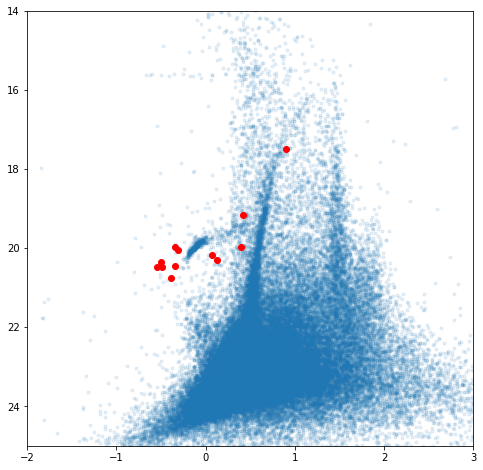

In [151]:
plt.figure(figsize=(8,8))
plt.xlim(-2,3)
plt.ylim(25,14)
plt.scatter(df0['g_r'],df0['mag_r'],marker='.',alpha=0.1)
#plt.scatter(dfhb0['g_r'],dfhb0['mag_r'],marker='.')
plt.scatter(dfmean_gr['mag_g'] - dfmean_gr['mag_r'], dfmean_gr['mag_r'],c='r')

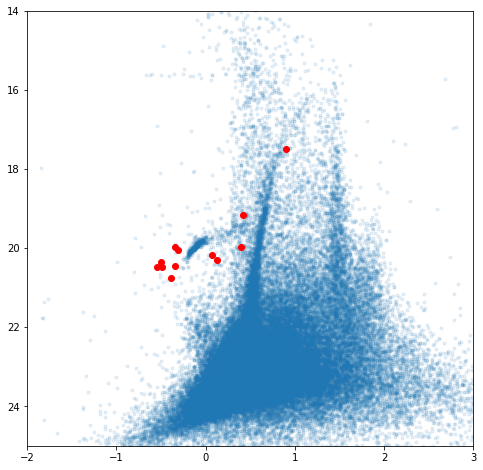

In [152]:
plt.figure(figsize=(8,8))
plt.xlim(-2,3)
plt.ylim(25,14)
plt.scatter(df0['g_r'],df0['mag_r'],marker='.',alpha=0.1)
#plt.scatter(dfhb0['g_r'],dfhb0['mag_r'],marker='.')
plt.scatter(dfmean_gr['mag_g'] - dfmean_gr['mag_r'], dfmean_gr['mag_r'],c='r')

In [153]:
dfmean.xs('1',level='ztf_fid').to_csv()

'locus_id,alert_id,survey,original_id,ra,dec,htm20,mjd,ingest_time,mag\n13460,77935924.5,1.0,918634342165014912,227.10590465,67.15821849999999,14842967467712.0,58672.63434606255,1563165946.375,19.850500345230103\n13461,99368404.39473684,1.0,917369238020278400,227.30724809736842,67.25926342105262,14842997365659.078,58671.36924220527,1562511870.0,18.39568248548006\n47512,106608983.45454545,1.0,923332955460465920,227.35015291818183,67.10100291818182,14842961895651.455,58677.332959790925,1564100117.6363637,20.360727136785332\n47530,107873113.21052632,1.0,925814097757119360,227.58443238947368,66.99699541052631,14843126133373.105,58679.81410148948,1563543982.4736843,19.59537124633789\n47567,78861145.0,1.0,934330990915015040,227.4033461,67.0250233,14843080747239.0,58688.33099539997,1563986958.0,20.00428581237793\n48101,125124214.5,1.0,946402477581681664,227.35693231666664,67.20375606666666,14843001387354.5,58700.4024826334,1565141534.8333333,19.747447331746418\n483425,80759357.0,1.0,936203530

In [154]:
qc.mydb_import('ursa_minor',dfmean.xs('1',level='ztf_fid').to_csv())

'OK'

In [155]:
qc.mydb_list()

'runaway\nursa_minor\n'

In [156]:
%%time

sql = '''SELECT  o.locus_id, ls8.ls_id, (q3c_dist(o.ra,o.dec,ls8.ra,ls8.dec)*3600.0) as dist_arcsec, 
            ls8.mag_g, ls8.mag_r, ls8.ra, ls8.dec
         FROM mydb://ursa_minor AS o
         LEFT JOIN LATERAL (
               SELECT ls.* 
                    FROM 
                        ls_dr8.tractor_n AS ls
                    WHERE
                        q3c_join(o.ra, o.dec, ls.ra, ls.dec, 3./3600)
                    ORDER BY
                        q3c_dist(o.ra,o.dec,ls.ra,ls.dec)
                    ASC LIMIT 1
               ) as ls8 ON true;'''

dfmch = qc.query(sql=sql, fmt='pandas')

CPU times: user 22 ms, sys: 2 ms, total: 24 ms
Wall time: 196 ms


In [157]:
dfmch

,locus_id,ls_id,dist_arcsec,mag_g,mag_r,ra,dec
0,13460,8796134717326422,0.086292,19.3541,19.3262,227.105850,67.158230
1,13461,8796134717331913,0.172473,17.3393,15.8932,227.307345,67.259293
2,47512,8796134680498672,0.037255,20.0484,19.5694,227.350179,67.101002
3,47530,8796134680496558,0.229742,18.9266,18.7590,227.584292,66.997028
4,47567,8796134680497185,0.097461,19.7971,19.6845,227.403412,67.025015
5,48101,8796134717329347,0.056330,20.3851,19.7055,227.356893,67.203760
6,483425,8796134717327271,0.078908,20.2200,20.0448,226.960616,67.157543
7,483427,8796134717331250,0.083027,20.3762,20.0734,227.465029,67.231871
8,505450,8796134680500208,0.029560,19.9950,19.8635,227.610086,67.124555
9,2197440,8796134680435549,0.109191,15.1844,14.8018,226.940364,67.109651


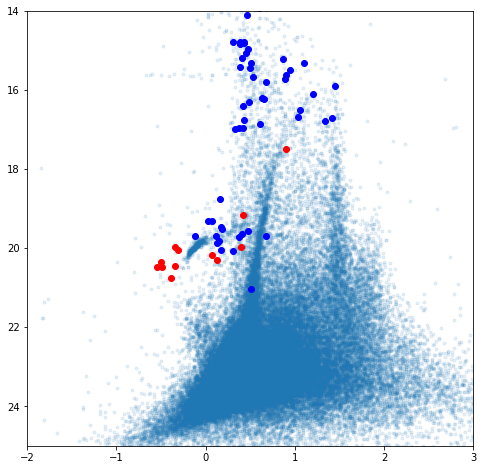

In [158]:
plt.figure(figsize=(8,8))
plt.xlim(-2,3)
plt.ylim(25,14)
plt.scatter(df0['g_r'],df0['mag_r'],marker='.',alpha=0.1)
#plt.scatter(dfhb0['g_r'],dfhb0['mag_r'],marker='.')
plt.scatter(dfmean_gr['mag_g'] - dfmean_gr['mag_r'], dfmean_gr['mag_r'],c='r')
plt.scatter(dfmch['mag_g'] - dfmch['mag_r'], dfmch['mag_r'], c='b')

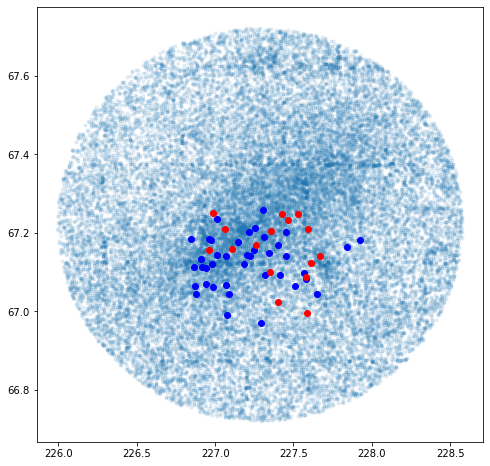

In [159]:
plt.figure(figsize=(8,8))
sel = df0['mag_r'] < 23
plt.scatter(df0['ra'][sel],df0['dec'][sel],marker='.',alpha=0.1)
#plt.scatter(dfmean['ra'],dfmean['dec'],c='r')
fg = dfmch['mag_r'] < 18
dwf = dfmch['mag_r'] > 18

plt.scatter(dfmch['ra'][fg],dfmch['dec'][fg],c='b')
plt.scatter(dfmch['ra'][dwf],dfmch['dec'][dwf],c='r')



In [ ]:
fg = dfmch['mag_r'] < 18
dwf = dfmch['mag_r'] > 18

In [248]:
dwfids = dfmch[dwf]['locus_id'].values.tolist()
len(dwfids)

16

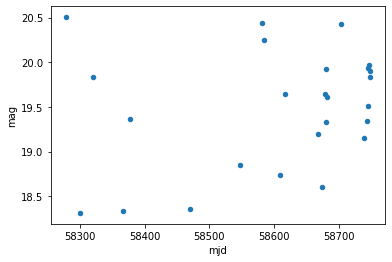

In [272]:
locus_id = dwfids[2]
alert_id, mjd, passband, mag, magerr, zeropoint, ra, dec = get_time_series_by_locus_id(
    locus_id,
    'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf', 'ztf_magzpsci', 'ra', 'dec',
    require=['ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf'],
)
# BUG: Make sure you typecast to the dtypes you expect
alert_id = alert_id.astype(int)
passband = passband.astype(int)
mjd = mjd.astype(float)
mag = mag.astype(float)
magerr = magerr.astype(float)
zeropoint = zeropoint.astype(float)
ra = ra.astype(float)
dec = dec.astype(float)

tmplist = list(zip(np.full_like(alert_id,locus_id), alert_id, mjd, passband, mag, magerr, ra, dec))

dftmp = pd.DataFrame(tmplist,columns=['locus_id','alert_id', 'mjd', 'passband', 'mag', 'magerr', 'ra', 'dec'])
fgrp = dftmp.groupby(['passband'])
fgrp.get_group(1)
fgrp.get_group(1).plot(kind='scatter',x='mjd',y='mag',)


In [274]:
len(fgrp.get_group(1))

25

In [275]:
def get_ls_periodogram(t,y,min_freq=1./1.,max_freq=1./0.1):
    
    """Compute Lomb-Scargle periodogram.
    
    Parameters
    ----------
    t : array
        Observation time array (e.g. MJD), ordered in ascending order.
    
    y : array
        Magnitude measurements at times ``t``.
        
    min_freq, max_freq : float or None
        The period finder can be guided by providing the min and max frequency
        in the ``y`` signal, in units 1/t. 
          min_freq = 1/longest expected period (in days)
          max_freq = 1/shortest expected perdiod (in days)
        The defaults are typical for RR Lyrae variability (RR Lyrae usually
        have a period of a fraction of one day).
        
    Returns
    -------
    period : array
        Phased period of the time-variable signal (fraction of the phase).
        
    power : array
        The periodogramm power as function if ``period``.
        
    """
    
    # Use astropy's LombScargle class
    ls = stats.LombScargle(t, y)

    # Compute the periodogram
    #   We guide the algorithm a bit:
    #     min_freq = 1/longest expected period (in days)
    #     max_freq = 1/shortest expected perdiod (in days)
    #   RR Lyrae usually have a period of a fraction of one day
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period, power


def get_best_period(period,power):
    
    """Return the period with highest power."""
    
    return period[np.argmax(power)]

def plot_periodogram(period,power,best_period=None,title='',ax=None):

    """Plot a periodogram.
    
    Parameters
    ----------
    
    period, power : array
        The period and power 1-d arrays as returned by :func:`get_ls_periodogram()`
    
    best_period : float or None
        If float, the value of this ``best_period`` will be marked in the plot.
    
    title : str
        Title of the figure. Default: ''.
    
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.8)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(title)
    
    if best_period is not None:
        ax.axvline(best_period,color='r',lw=0.5);
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')
        
def get_folded_phase(t,best_period):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    
    return phase

def plot_folded_lightcurve(t,y,best_period,dy=None,ax=None):
    
    """Plot folded lightcurve.
    
    Parameters
    ----------
    
    t, y : array
        Time and magnitude 1-d arrays
        
    best_period : float
        True period of the signal.
        
    dy : array or None
        If array, the values are the uncertainies on ``y``, and the plot will show errorbars.
        If None, the plot will have no errorbars.
        
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """

    phase = get_folded_phase(t,best_period)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    marker = '.'
    ms = 10
    lw = 1
    color = 'g'
    alpha = 0.6    
    
    if dy is not None:
        ax.errorbar(phase,y,yerr=dy,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
    else:
        ax.plot(phase,y,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
            
    ax.set_title('phased lightcurve')
    ax.invert_yaxis()
    ax.set_xlabel('phase (days)')
    ax.set_ylabel('magnitude');


In [276]:
t = fgrp.get_group(1)['mjd'].values
y = fgrp.get_group(1)['mag'].values

In [280]:
period, power = get_ls_periodogram(t,y,min_freq=1./2.,max_freq=1./0.1)
best_period = get_best_period(period,power)

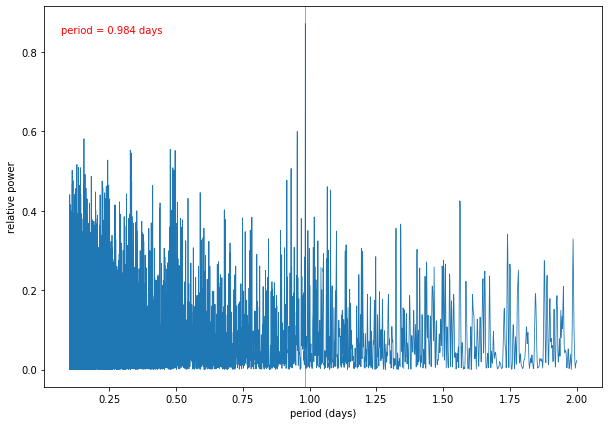

In [281]:
plot_periodogram(period,power,best_period,title='')

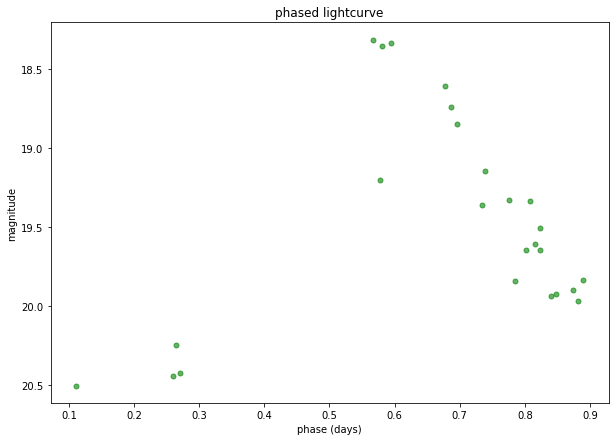

In [282]:
plot_folded_lightcurve(t,y,best_period)

0.9836737276657892

In [ ]:
hb0 = (df0['g_r'] > -0.8) & (df0['g_r'] < 0.2) & (df0['mag_r'] > 19) & (df0['mag_r'] < 21)
dfhb0 = df0[hb0]
blue = (df0['g_r'] < 0.2)
dfblue = df0[blue]

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(dfhb0['ra'],dfhb0['dec'],marker='.',alpha=1)
plt.scatter(dfm['ra'],dfm['dec'],c='r')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(dfblue['ra'],dfblue['dec'],marker='.',alpha=1)
plt.scatter(dfm['ra'],dfm['dec'],c='r')

In [117]:
def main():
    locus_ids = list(dfmch[dwf]['locus_id'].values)
    # Get lightcurve for each locus
    for locus_id in locus_ids:
        alert_id, mjd, passband, mag, magerr, zeropoint = get_time_series_by_locus_id(
            locus_id,
            'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf', 'ztf_magzpsci',
            require=['ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf'],
        )
        # BUG: Make sure you typecast to the dtypes you expect
        alert_id = alert_id.astype(int)
        passband = passband.astype(int)
        mjd = mjd.astype(float)
        mag = mag.astype(float)
        magerr = magerr.astype(float)
        zeropoint = zeropoint.astype(float)

        print(list(zip(alert_id, passband, mag, magerr)))

main()

TypeError: Object of type int64 is not JSON serializable

In [120]:
locus_ids = list(dfmch[dwf]['locus_id'].values)
locus_ids

[13460,
 47512,
 47530,
 47567,
 48101,
 483425,
 483427,
 505450,
 2715020,
 2770575,
 2994091,
 3046847,
 3547502,
 3849539,
 3898613,
 5720467]

In [ ]:
df_fs = pd.read_json('ANTARES_search_results.json')

In [ ]:
with open('ANTARES_search_results.json') as json_file:
    data = json.load(json_file)
